# Computational Physics Blatt 04
Anne, Fabian und Asliddin 

In [1]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit

matplotlib.rcParams["figure.figsize"] = [12, 8]
%matplotlib inline

T_MAX = 100

## a)

In [53]:
def RKDP(f, y0, t0, tmax, h, digits=None, **kwargs):
    dim = len(y0)
    coef = {  # Coefficients for the Dormand-Prince method, padded with zeros for the 6th order
        "k2": np.array([1 / 5, 0, 0, 0, 0, 0]).reshape(-1, 1),
        "k3": np.array([3 / 40, 9 / 40, 0, 0, 0, 0]).reshape(-1, 1),
        "k4": np.array([44 / 45, -56 / 15, 32 / 9, 0, 0, 0]).reshape(-1, 1),
        "k5": np.array(
            [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729, 0, 0]
        ).reshape(-1, 1),
        "k6": np.array(
            [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656, 0]
        ).reshape(-1, 1),
        "y": np.array(
            [35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84]
        ).reshape(-1, 1),
        "t": np.array([0, 1 / 5, 3 / 10, 4 / 5, 8 / 9, 1]),
    }

    t = t0
    y = y0
    fp = partial(f, **kwargs)
    while t < tmax:
        ks = np.zeros((6, dim))
        ks[0] = h * fp(t, y)
        ks[1] = h * fp(t + h * coef["t"][1], y + np.sum(ks * coef["k2"]))
        ks[2] = h * fp(t + h * coef["t"][2], y + np.sum(ks * coef["k3"]))
        ks[3] = h * fp(t + h * coef["t"][3], y + np.sum(ks * coef["k4"]))
        ks[4] = h * fp(t + h * coef["t"][4], y + np.sum(ks * coef["k5"]))
        ks[5] = h * fp(t + h * coef["t"][5], y + np.sum(ks * coef["k6"]))
        y += np.sum(coef["y"] * ks, axis=0)
        if digits:
            y = np.round(y, digits)
        t += h
        yield t, *y

## b)

In [3]:
def lorentz(t, y, sigma, r, beta):
    x_dot = sigma * (y[1] - y[0])
    y_dot = y[0] * (r - y[2]) - y[1]
    z_dot = y[0] * y[1] - beta * y[2]
    return np.array([x_dot, y_dot, z_dot])

In [4]:
y0 = np.array([2, 3, 14], dtype=float)  # prevent type-casting errors
rkdp = RKDP(lorentz, y0, 0, T_MAX, 0.001, sigma=10, r=28, beta=8 / 3)
system = np.array(list(rkdp))
time = system[:, 0]
trajectory = system[:, 1:]

Text(0.5, 1.0, 'Lorenz Attractor, XZ Projection')

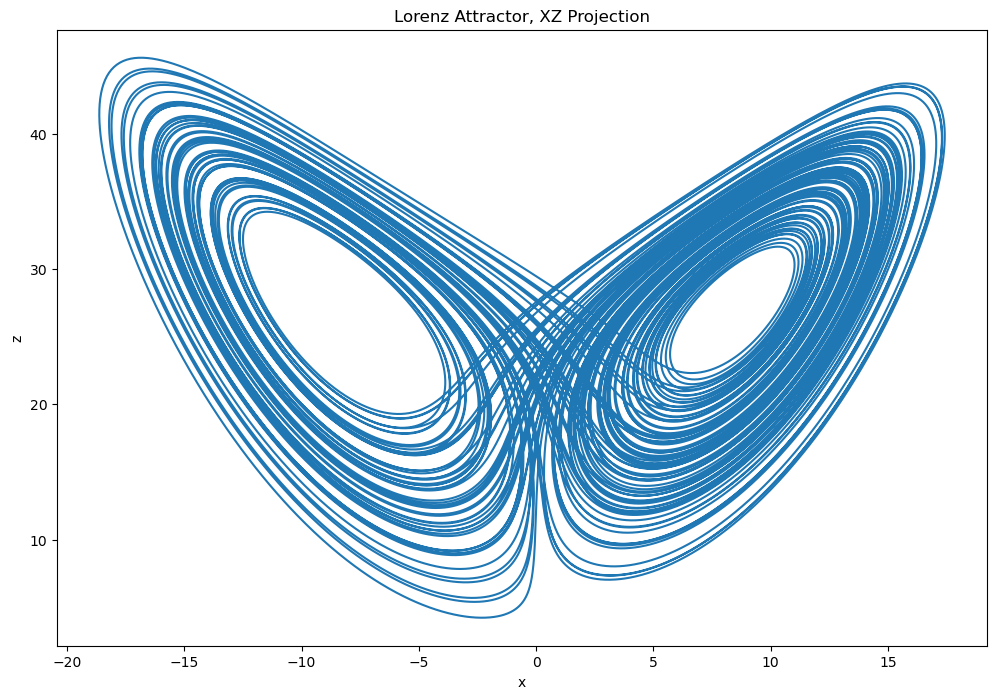

In [5]:
plt.plot(trajectory[:, 0], trajectory[:, 2])
plt.xlabel("x")
plt.ylabel("z")
plt.title("Lorenz Attractor, XZ Projection")

Text(0.5, 0.92, 'Lorenz Attractor')

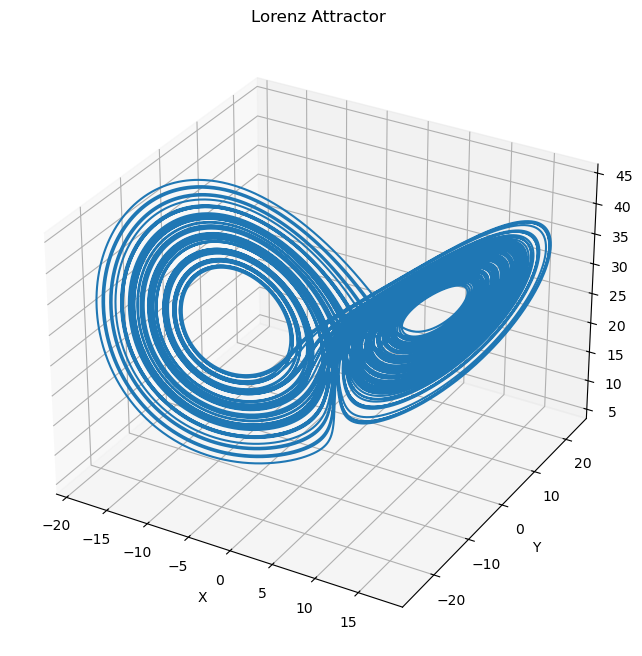

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")

ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")  # strangly missing
plt.title("Lorenz Attractor")

## c)

In [7]:
y0_eps = np.array([2, 3, 14 + 1e-9], dtype=np.float64)
rkdp2 = RKDP(lorentz, y0_eps, 0, T_MAX, 0.001, sigma=10, r=28, beta=8 / 3)
system2 = np.array(list(rkdp2))
time2 = system2[:, 0]
trajectory2 = system2[:, 1:]

Text(0.5, 1.0, 'Lorenz Attractor, XZ Projection, slightly changed initial condition')

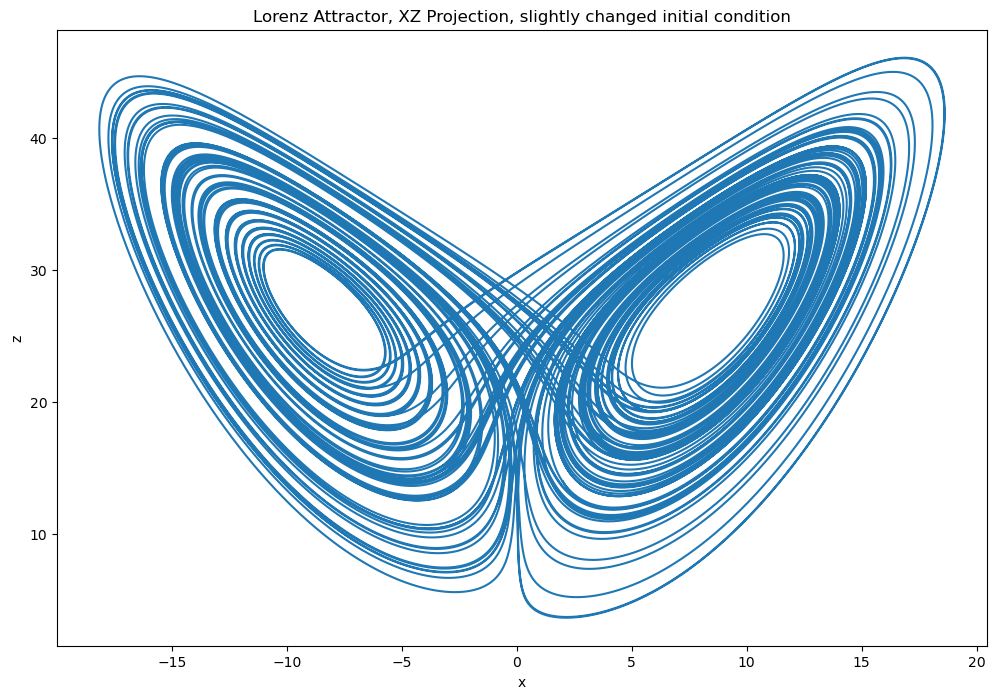

In [8]:
plt.plot(trajectory2[:, 0], trajectory2[:, 2])
plt.xlabel("x")
plt.ylabel("z")
plt.title("Lorenz Attractor, XZ Projection, slightly changed initial condition")

Text(0.5, 1.0, 'combined Lorenz Attractor, XZ Projection')

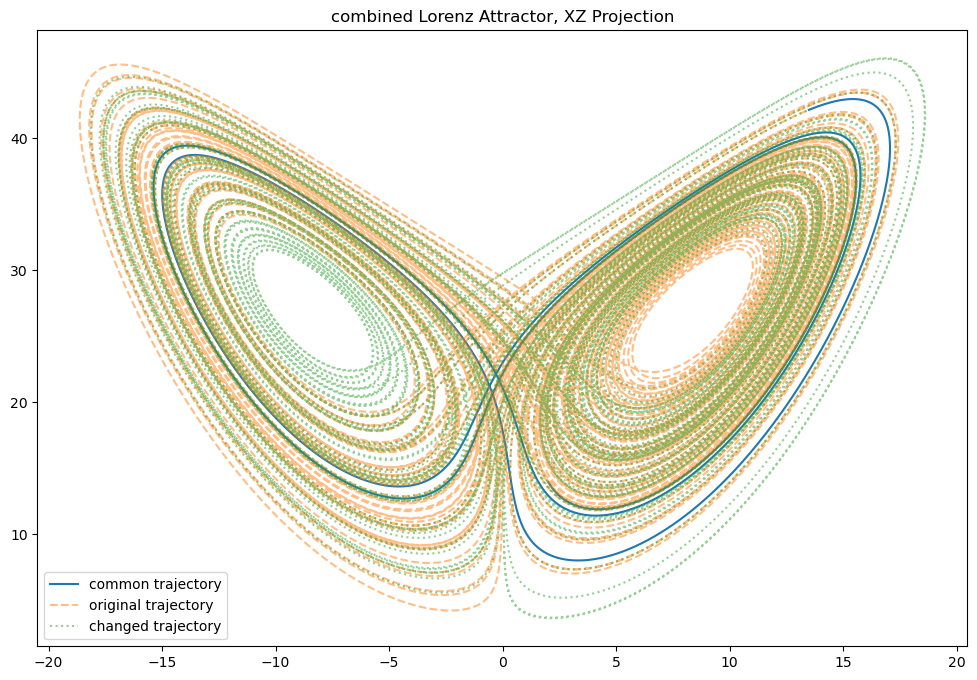

In [27]:
traj_mask = np.all(np.isclose(trajectory, trajectory2, rtol=1e-7), axis=1)
div_point = np.argmin(traj_mask)
plt.plot(
    trajectory[:div_point, 0],
    trajectory[:div_point, 2],
    ls="solid",
    label="common trajectory",
)
plt.plot(
    trajectory[div_point:, 0],
    trajectory[div_point:, 2],
    ls="dashed",
    alpha=0.5,
    label="original trajectory",
)
plt.plot(
    trajectory2[div_point:, 0],
    trajectory2[div_point:, 2],
    ls="dotted",
    alpha=0.5,
    label="changed trajectory",
)
plt.legend()
plt.title("combined Lorenz Attractor, XZ Projection")

Text(0.5, 1.0, 'divirgence of Lorenz Attractor, XZ Projection')

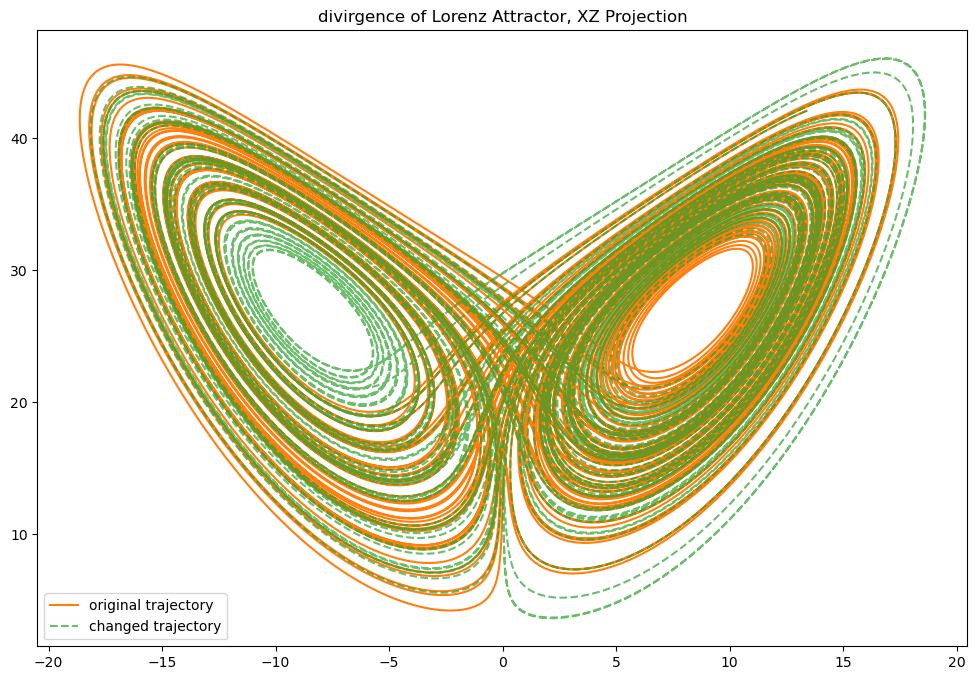

In [28]:
plt.plot(
    trajectory[div_point:, 0],
    trajectory[div_point:, 2],
    ls="solid",
    c="tab:orange",
    label="original trajectory",
)
plt.plot(
    trajectory2[div_point:, 0],
    trajectory2[div_point:, 2],
    ls="dashed",
    c="tab:green",
    alpha=0.7,
    label="changed trajectory",
)
plt.legend()
plt.title("divirgend part of Lorenz Attractor, XZ Projection")

## d)

In [29]:
delta_y = np.linalg.norm(trajectory2 - trajectory, axis=1)


def liapunov(t, lambda_, a):
    return np.exp(lambda_ * t) * a


params, cov = curve_fit(liapunov, time, delta_y)

Text(0.5, 1.0, 'example for get_plateau_start')

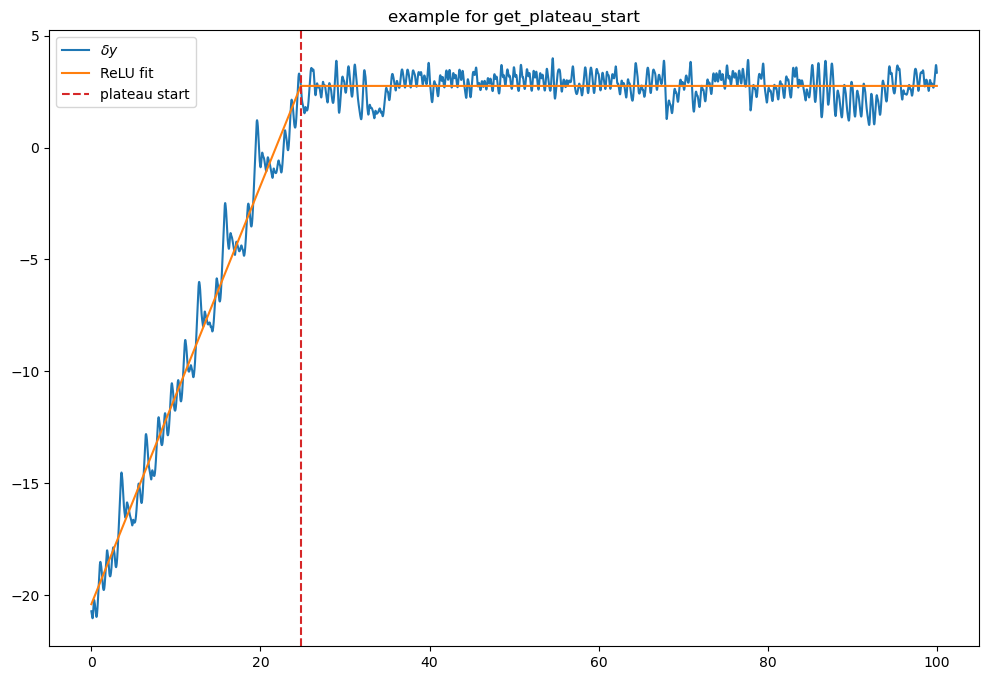

In [183]:
def relu(x, a, b, c):
    return np.minimum(a * x + b, c)


def get_plateau_start(
    delta_y, time
):  # This was way more work than doing part f) by hand
    """Fitts a relu function to the data and returns the time at which the function plateaus."""
    logY = np.log(delta_y)

    params, cov = curve_fit(
        relu, time[delta_y > 0], logY[delta_y > 0], p0=[1, np.min(logY), np.max(logY)]
    )
    return time[np.where(relu(time, *params) == params[2])[0][0]]


params, cov = curve_fit(relu, time, np.log(delta_y), p0=[1, -20, 2])
plt.plot(time, np.log(delta_y), label="$\delta y$")
plt.plot(time, relu(time, *params), label="ReLU fit")
plt.axvline(
    get_plateau_start(delta_y, time), c="tab:red", ls="--", label="plateau start"
)
plt.legend()
plt.title("example for get_plateau_start")

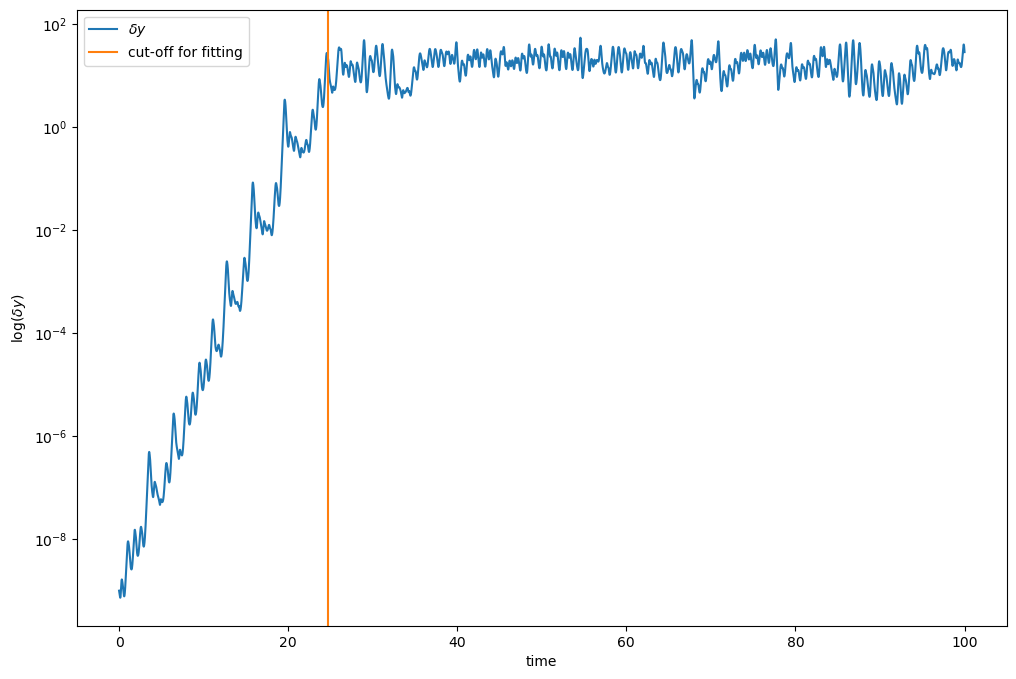

In [141]:
delta_y = np.linalg.norm(trajectory2 - trajectory, axis=1)
t_cutoff = get_plateau_start(delta_y, time)

plt.plot(time, delta_y, label="$\delta y$")
plt.yscale("log")
plt.ylabel(r"log($\delta y$)")
plt.axvline(x=t_cutoff, c="tab:orange", label="cut-off for fitting")
plt.xlabel("time")
plt.legend()

In [42]:
params, cov = curve_fit(liapunov, time[time < t_cutoff], delta_y[time < t_cutoff])

Text(0.5, 1.0, 'Liapunov exponent fit comparison')

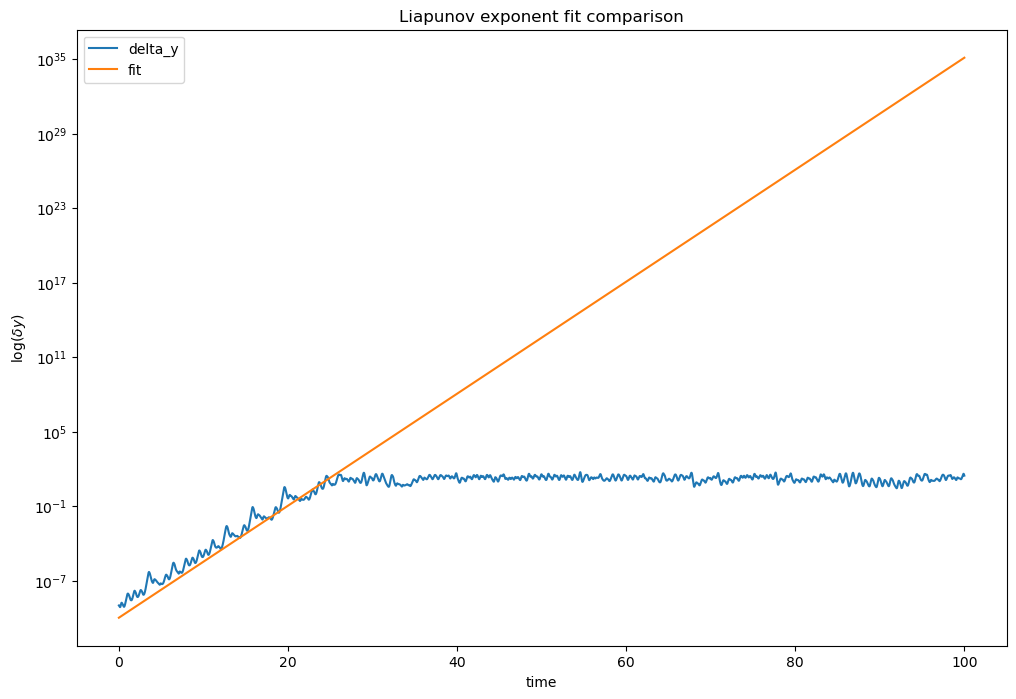

In [48]:
plt.plot(time, delta_y, label="delta_y")
plt.plot(time, liapunov(time, *params), label="fit")
plt.yscale("log")
plt.ylabel(r"log($\delta y$)")
plt.xlabel("time")
plt.legend()
plt.title("Liapunov exponent fit comparison")

In [50]:
print(f"Liapunov exponent: {params[0]}")

Liapunov exponent: 1.0384736507360466


## e)

In [56]:
rkdp3 = RKDP(
    lorentz,
    y0,
    0,
    T_MAX,
    0.001,
    digits=10,
    sigma=10,
    r=28,
    beta=8 / 3,
)
system3 = np.array(list(rkdp3))
time3 = system3[:, 0]
trajectory3 = system3[:, 1:]

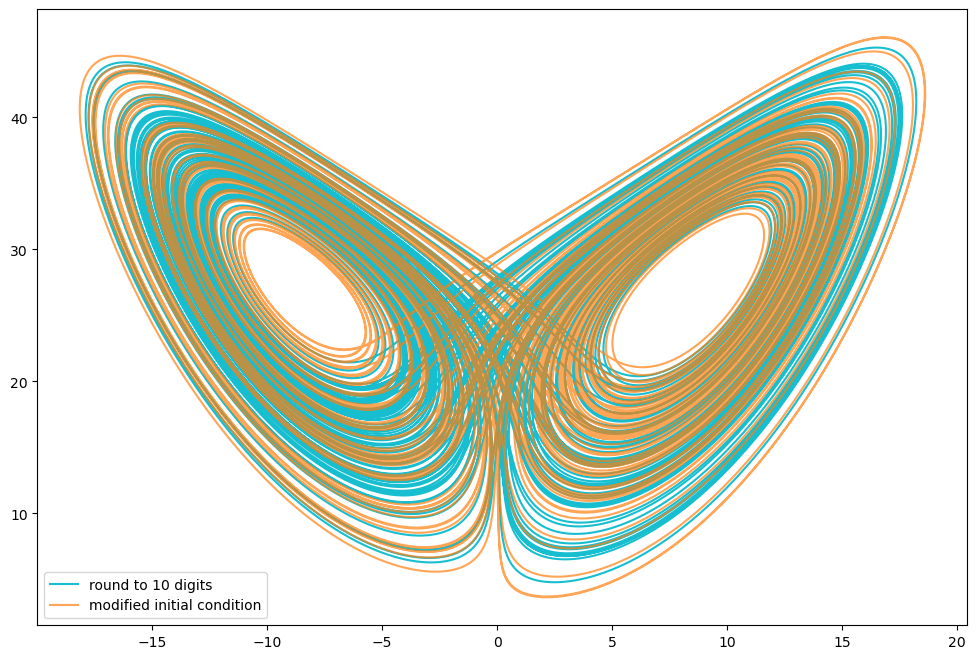

In [62]:
plt.plot(trajectory3[:, 0], trajectory3[:, 2], c="tab:cyan", label="round to 10 digits")
plt.plot(
    trajectory2[:, 0],
    trajectory2[:, 2],
    c="tab:orange",
    label="modified initial condition",
    alpha=0.7,
)
plt.legend()

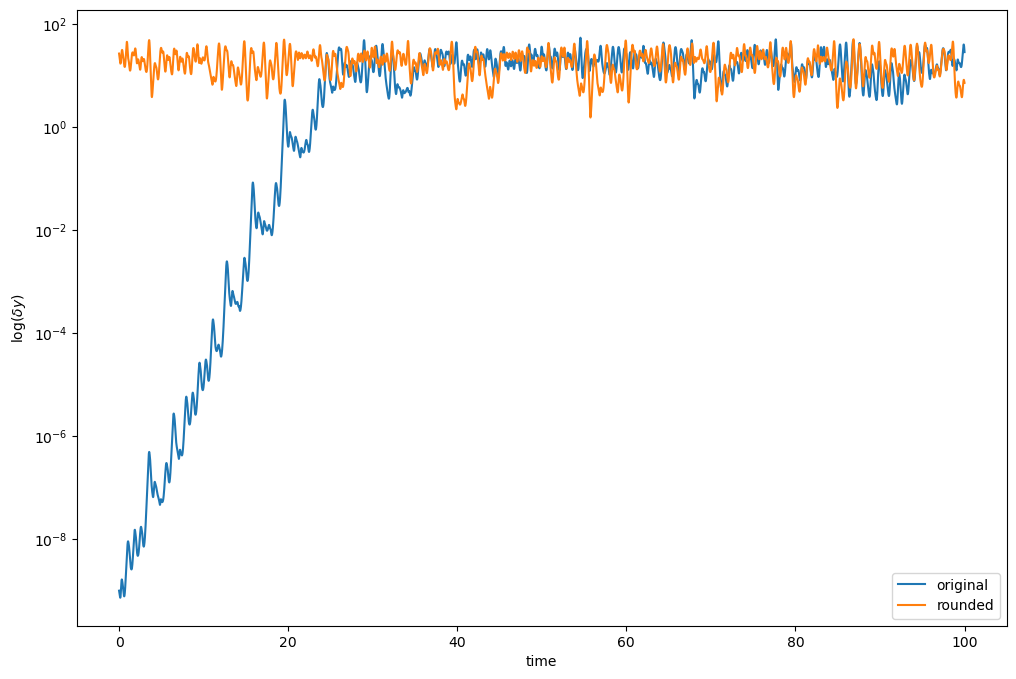

In [65]:
delta_y3 = np.linalg.norm(trajectory3 - trajectory, axis=1)

plt.plot(time, delta_y, label="original")
plt.plot(time, delta_y3, label="rounded")
plt.yscale("log")
plt.ylabel(r"log($\delta y$)")
plt.xlabel("time")
plt.legend()

When introducing errors due to rounding, $\delta y$ stays in the same (big) order of magnitude. The "natural" divergence has an exponential increasing error instead.

## f)

In [189]:
def liapFromLorePara(sigma, r, beta, t0, tmax, h, digits=None):
    y0 = np.array([2, 3, 14], dtype=float)  # prevent type-casting errors
    rkdp0 = RKDP(lorentz, y0, t0, tmax, h, digits=digits, sigma=sigma, r=r, beta=beta)
    system0 = np.array(list(rkdp0))
    time0 = system0[:, 0]
    trajectory0 = system0[:, 1:]

    y1 = np.array([2, 3, 14 + 1e-9], dtype=float)  # prevent type-casting errors
    rkdp1 = RKDP(lorentz, y1, t0, tmax, h, digits=digits, sigma=sigma, r=r, beta=beta)
    system1 = np.array(list(rkdp1))
    time1 = system1[:, 0]
    trajectory1 = system1[:, 1:]

    delta_y = np.linalg.norm(trajectory0 - trajectory1, axis=1)
    try:
        t_cutoff = get_plateau_start(delta_y, time0)
    except:
        return 0
    if t_cutoff < 0.5:
        return 0
    try:
        params, cov = curve_fit(
            liapunov, time1[time1 < t_cutoff], delta_y[time1 < t_cutoff]
        )
    except:
        return 0
    return params[0]

/tmp/ipykernel_790/3651161043.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  params, cov = curve_fit(
/tmp/ipykernel_790/3651161043.py:9: RuntimeWarning: divide by zero encountered in log
  logY = np.log(delta_y)
/tmp/ipykernel_790/3651161043.py:9: RuntimeWarning: divide by zero encountered in log
  logY = np.log(delta_y)
/tmp/ipykernel_790/3651161043.py:9: RuntimeWarning: divide by zero encountered in log
  logY = np.log(delta_y)
/tmp/ipykernel_790/3651161043.py:9: RuntimeWarning: divide by zero encountered in log
  logY = np.log(delta_y)
/tmp/ipykernel_790/3651161043.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  params, cov = curve_fit(
/tmp/ipykernel_790/3651161043.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  params, cov = curve_fit(
/tmp/ipykernel_790/3651161043.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  params, cov = curve_fit(


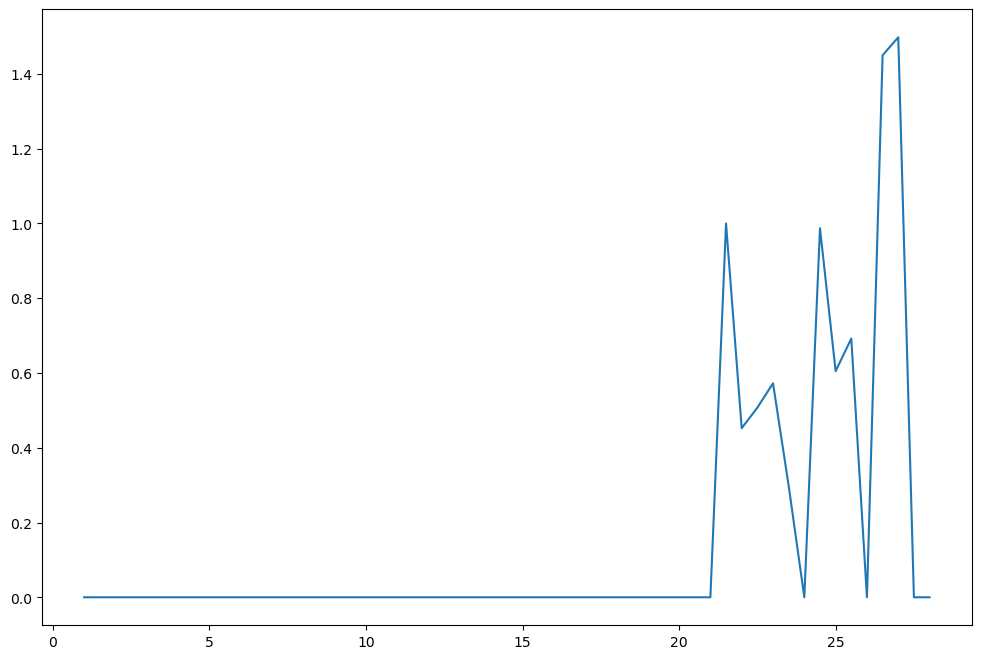

In [190]:
from multiprocessing import Pool


rs = np.linspace(1, 28, 55)
sigma = 10
beta = 8 / 3
t0 = 0
tmax = 50
h = 0.001


def liapWrapper(r):
    return liapFromLorePara(sigma, r, beta, t0, tmax, h)


with Pool(4) as p:
    liap = p.map(liapWrapper, rs)

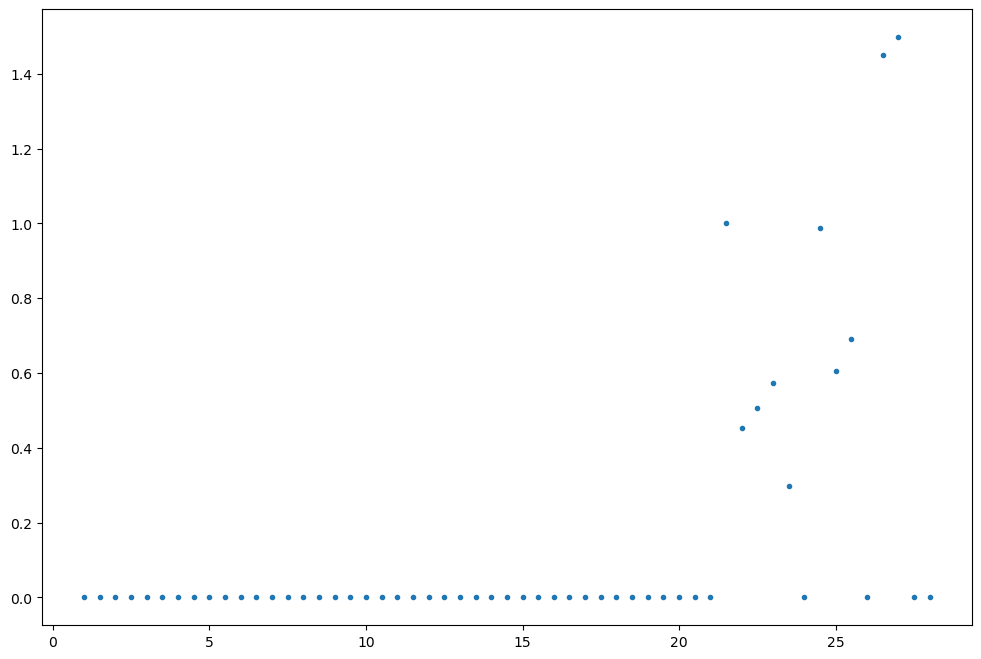

In [191]:
plt.plot(rs, liap, ".")